In [1]:
import os
import torch
import logging
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

import random
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

seed = 30255    
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if USE_CUDA:
    torch.cuda.manual_seed(seed)

# For uploading data to Colab see, e.g., 
# https://medium.com/@philipplies/transferring-data-from-google-drive-to-google-cloud-storage-using-google-colab-96e088a8c041    

from google.colab import drive 
drive.mount('/content/gdrive')
PATH = "gdrive/MyDrive/climate-paper-classifier/data"
    


Using cpu.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from transformers import BertTokenizer
import os

path = os.path.abspath(os.path.join(PATH, 'preprocessed_data.csv'))
df = pd.read_csv(path)

seed = 30255    
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

class Processing():
    """
    Class for processing raw data and preparing it for the dataloaders.
    """
    def __init__(self, seq_len=512, batch_size=32):
        self.df = pd.DataFrame()
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        self.vocab = pd.DataFrame()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_words = 0

    def load(self):
        from sklearn import preprocessing
        self.df = pd.read_csv(path)
        self.df = self.df[['CLASS', 'SPACY_PREPROCESSED']]
        
        self.df = self.df.dropna()
        self.df['SPACY_PREPROCESSED'] = self.df['SPACY_PREPROCESSED'].str.replace(r'<[^<>]*>', '', regex=True) # drop HTML tags

        le = preprocessing.LabelEncoder()
        le.fit(self.df['CLASS'])
        self.df['LABEL'] = le.transform(self.df['CLASS'])

        self.df = self.df[['LABEL', 'SPACY_PREPROCESSED']]

        self.df['LABEL'].value_counts(dropna=False)
        

        self.text = self.df["SPACY_PREPROCESSED"].values
        self.target = self.df["LABEL"].values
    
    def tokenize_and_build_vocabulary(self):
        from torchtext.data.utils import get_tokenizer
        from torchtext.vocab import build_vocab_from_iterator

        tokenizer = get_tokenizer('basic_english')

        def yield_tokens(train_iter):
            for text in train_iter:
                yield tokenizer(text)

        # tokenize and build vocab over all words 
        train_iter = iter(self.text.tolist())
        self.tokenized = list(map(lambda text : tokenizer(text), train_iter))
        # re-initialize train iter
        train_iter = iter(self.text.tolist())
        # build vocab
        self.vocab = build_vocab_from_iterator(
            yield_tokens(train_iter), specials=["<unk>"], max_tokens = self.seq_len)
        self.vocab.set_default_index(self.vocab['<unk>'])
        # set num words in vocab
        self.num_words = len(self.vocab)

    def word_to_idx(self):
        # Index representation	
        self.index_representation = list()
        for sentence in self.tokenized:
            temp_sentence = list()
            for word in sentence:
                idx = self.vocab.lookup_indices([word])
                temp_sentence.extend(self.vocab.lookup_indices([word]))
            self.index_representation.append(temp_sentence)

    def padding_sentences(self):
        # Pad each sentence which does not fulfill the required len
        # Zero padding

        pad_idx = 0
        self.padded = list()
        for sentence in self.index_representation: # tensors
            if len(sentence) < self.seq_len:
                while len(sentence) < self.seq_len: #max_length
                    sentence.append(pad_idx)
                sentence = torch.tensor(sentence)
                self.padded.append(sentence)
            else:
                sentence = torch.tensor(sentence[:self.seq_len])
                self.padded.append(sentence) # new code
        self.padded = torch.stack(self.padded)

    def split_data(self):
        self.target = torch.tensor(self.target)
        # Concatenating the Padded Vectors, Labels
        dataset = TensorDataset(self.padded, self.target)

        # compute train/validation/test split sizes
        train_size = int(0.7 * len(dataset))
        val_size = int(0.15 * len(dataset))
        test_size = len(dataset) - train_size - val_size

        # split dataset randomly into train/validation/test sets
        train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

        # create data loaders for each set
        self.train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=True)


    def process_all(self):
        self.load()
        self.tokenize_and_build_vocabulary()
        self.word_to_idx()
        self.padding_sentences()
        self.split_data()

    def prints(self):
        # Task 1
        print(f"Task 1: The number of words in the Vocab object is {len(self.vocab)}.")

        # # Task 2
        stoi_dict = self.vocab.get_stoi()
        word = "energy"
        print(f"Task 2: The index of the word '{word}' is {stoi_dict[word]}.")

        # # Task 3
        itos_dict = self.vocab.get_itos()
        idx = 500
        print(f"Task 3: The word at index 500 is '{itos_dict[idx]}'.")

        # # Task 4:
        word = "<unk>"
        print(f"Task 4: The index of the word '{word}' is {stoi_dict[word]}. Resetting default index to this value.")


In [4]:
data = Processing()
data.load()

In [5]:
import torch
import torch.nn as nn
import math
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# source: https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-conv1d-for-text-classification

class CNN(nn.Module):
    """
    Defining the CNN class. This class contains only a forward pass method.
    Inputs: use_glove=True, kernel_size=5, channel_size=32, seq_len=512, batch_size=32
    """
    def __init__(self, use_glove=True, kernel_size=5, channel_size=32, seq_len=512, batch_size=32):
        super(CNN, self).__init__()
        self.data = Processing(seq_len, batch_size)
        self.data.process_all()
        self.use_glove = use_glove
        self.embedding_layer = nn.Embedding(num_embeddings=len(self.data.vocab), embedding_dim=128)
        if use_glove:
            self.embedding_pretrained = nn.Embedding.from_pretrained(glove_vectors, freeze=False)
            self.conv1 = nn.Conv1d(300, channel_size, kernel_size=kernel_size, padding="same")
            self.conv2 = nn.Conv1d(channel_size, channel_size, kernel_size=kernel_size, padding="same")
        else:
          self.conv1 = nn.Conv1d(128, channel_size, kernel_size=kernel_size, padding="same")
          self.conv2 = nn.Conv1d(channel_size, channel_size, kernel_size=kernel_size, padding="same")

        self.pooling1 = nn.MaxPool1d(2)
        self.pooling2 = nn.MaxPool1d(2)
        self.linear = nn.Linear(channel_size, 5)

    def forward(self, X_batch):
        if self.use_glove:
          x = self.embedding_pretrained(X_batch)
          x = x.transpose(1, 2)
          x = nn.functional.relu(self.conv1(x))
          x = self.pooling1(x)
          x = nn.functional.relu(self.conv2(x))
          x = self.pooling2(x)
          x, _ = x.max(dim=-1)
          x = self.linear(x)
          return x
        else:
          x = self.embedding_layer(X_batch)
          # Transpose the tensor to shape [16, 128, 930]
          x = x.transpose(1, 2)
          x = nn.functional.relu(self.conv1(x))
          x = self.pooling1(x)
          x = nn.functional.relu(self.conv2(x))
          x = self.pooling2(x)
          x, _ = x.max(dim=-1)
          x = self.linear(x)
          return x

In [6]:
import os
!pip install torchtext
import torchtext

# Inititalize GloVe vectors
data = Processing()
data.process_all()

cache_dir: str = '~/.vector_cache'
glove = torchtext.vocab.GloVe('6B', cache=cache_dir)

print(f"Glove embedding files:\
    {os.listdir(cache_dir)} in {os.path.abspath(cache_dir)}")

glove_vectors = glove.get_vecs_by_tokens(data.vocab.get_itos())
print(f"Glove vectors tensor shape: {glove_vectors.shape}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Glove embedding files:    ['glove.6B.zip', 'glove.6B.100d.txt', 'glove.6B.300d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt.pt', 'glove.6B.50d.txt'] in /content/~/.vector_cache
Glove vectors tensor shape: torch.Size([512, 300])


In [7]:

from sklearn.metrics import accuracy_score
# source: https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-conv1d-for-text-classification
def get_loss_and_acc(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)
        return losses, accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())
    


torch.Size([16, 512]) torch.Size([16])
Epoch 0 Step 100 Train Loss: 1.411 Valid Loss: 1.017 Valid Acc: 0.641
Epoch 0 Step 200 Train Loss: 1.145 Valid Loss: 0.774 Valid Acc: 0.724
Epoch 1 Step 100 Train Loss: 0.655 Valid Loss: 0.740 Valid Acc: 0.726
Epoch 1 Step 200 Train Loss: 0.633 Valid Loss: 0.806 Valid Acc: 0.720
Epoch 2 Step 100 Train Loss: 0.480 Valid Loss: 0.735 Valid Acc: 0.737
Epoch 2 Step 200 Train Loss: 0.501 Valid Loss: 0.700 Valid Acc: 0.747
Epoch 3 Step 100 Train Loss: 0.357 Valid Loss: 0.737 Valid Acc: 0.744
Epoch 3 Step 200 Train Loss: 0.369 Valid Loss: 0.750 Valid Acc: 0.749
Epoch 4 Step 100 Train Loss: 0.277 Valid Loss: 0.694 Valid Acc: 0.769
Epoch 4 Step 200 Train Loss: 0.276 Valid Loss: 0.747 Valid Acc: 0.762
Epoch 5 Step 100 Train Loss: 0.184 Valid Loss: 0.770 Valid Acc: 0.757
Epoch 5 Step 200 Train Loss: 0.199 Valid Loss: 0.803 Valid Acc: 0.739
Epoch 6 Step 100 Train Loss: 0.103 Valid Loss: 0.861 Valid Acc: 0.736
Epoch 6 Step 200 Train Loss: 0.112 Valid Loss: 0.89

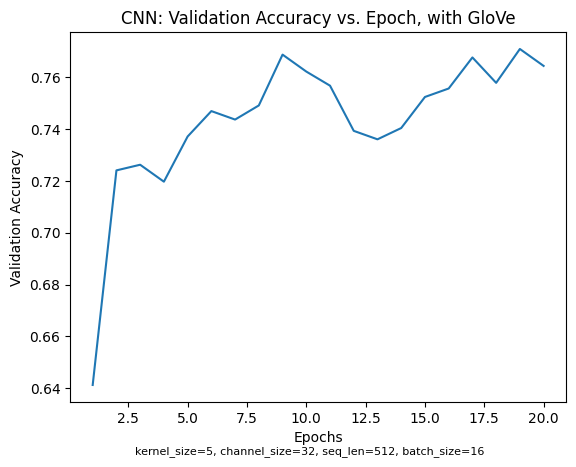

In [8]:
seed = 30255    
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
%matplotlib inline

def train(use_glove=True, kernel_size=5, channel_size=32, 
          seq_len=512, batch_size=32, plot_title=""):
  """Train the model for 10 epochs
  Inputs: use_glove=True, kernel_size=5, channel_size=32, 
          seq_len=512, batch_size=32, plot_title=""
  Outputs: Best model and test set dataloader
  """
  # Model      
  model = CNN(use_glove=use_glove, kernel_size=kernel_size, 
              channel_size=channel_size, seq_len=seq_len, 
              batch_size=batch_size)
  # Opmization function
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  # Loss function
  loss_fn = nn.CrossEntropyLoss()
  # Data
  data = model.data
  loader_train = data.train_loader
  loader_val = data.val_loader
  loader_test = data.test_loader

  for X, Y in loader_val:
      print(X.shape, Y.shape)
      break

  epochs = 10

  all_losses = []
  all_acc = []
  best_model = None

  for i in range(epochs):
      losses = []
      for k, (X, Y) in enumerate(loader_train):
          Y_preds = model(X)
          loss = loss_fn(Y_preds, Y)
          losses.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          clip_grad_norm_(model.parameters(), 1)

          step = (k+1)
          if step % 100 == 0:
              loss, accuracy = CalcValLossAndAccuracy(model, loss_fn, loader_val)

              all_acc.append(accuracy)
              print("Epoch", i, "Step", step, "Train Loss: {:.3f}".format(torch.tensor(losses).mean()), 
                    "Valid Loss: {:.3f}".format(torch.tensor(loss).mean()),
                    "Valid Acc: {:.3f}".format(accuracy))
              if len(all_losses) > 0:
                if torch.tensor(loss).mean() > all_losses[-1]:
                  model_copy = type(model)(use_glove=use_glove, 
                                           kernel_size=kernel_size, 
                                           channel_size=channel_size, 
                                           seq_len=seq_len, 
                                           batch_size=batch_size)
                  model_copy.load_state_dict(model.state_dict()) # copy weights and stuff
                  best_model = model_copy
              else:
                all_losses.append(torch.tensor(loss).mean())
                model_copy = type(model)(use_glove=use_glove, 
                                         kernel_size=kernel_size, 
                                         channel_size=channel_size, 
                                         seq_len=seq_len, 
                                         batch_size=batch_size)
                model_copy.load_state_dict(model.state_dict()) # copy weights and stuff
                best_model = model_copy

  caption = "kernel_size=5, channel_size=32, seq_len=512, batch_size=16"
  plt.plot(range(1, (2*epochs + 1)), all_acc)
  plt.title(plot_title)
  plt.xlabel("Epochs")
  plt.ylabel("Validation Accuracy")
  plt.figtext(0.5, 0.001, caption, wrap=True, horizontalalignment='center', fontsize=8)
  plt.show()

  return best_model, loader_test

kernel_size=5
channel_size=32
seq_len=512
batch_size=16
plot_title = "CNN: Validation Accuracy vs. Epoch, with GloVe"

best_model, loader_test = train(use_glove=True, kernel_size=kernel_size, 
                                channel_size=channel_size, 
                                seq_len=seq_len, 
                                batch_size=batch_size,
                                plot_title=plot_title)



In [9]:
import gc
# source: https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-conv1d-for-text-classification
def predict(model, loader):
    """Run the evaluation function on test data. 
    Inputs: model, test dataloader
    Outputs: Y_actual, Y_predicted
    """
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), nn.functional.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = predict(best_model, loader_test)
!pip install sklearn
from sklearn.metrics import f1_score

labels = ["Energy Storage, Conversion, and Utilization","Environmental Sciences",
          "Fission and Nuclear Technologies","Fossil Fuels","Renewable Energy Sources"]
f1 = f1_score(Y_actual, Y_preds, average=None, labels=[0,1,2,3,4])
logging.info(f"Best Model F1 Score={f1}")

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
import pandas as pd
print(classification_report(Y_actual, Y_preds, target_names=labels))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
                                             precision    recall  f1-score   support

Energy Storage, Conversion, and Utilization       0.69      0.71      0.70       189
                     Environmental Sciences       0.75      0.70      0.72       179
           Fission and Nuclear Technologies       0.85      0.82      0.83       184
                               Fossil Fuels       0.78      0.72      0.75       180
                   Renewable Energy Sources       0.62      0.70      0.65       186

                                   accuracy                           0.73       918
                                  macro avg       0.74      0.73      0.73       918
                               weighted avg       0.74      0.73      0.73       918



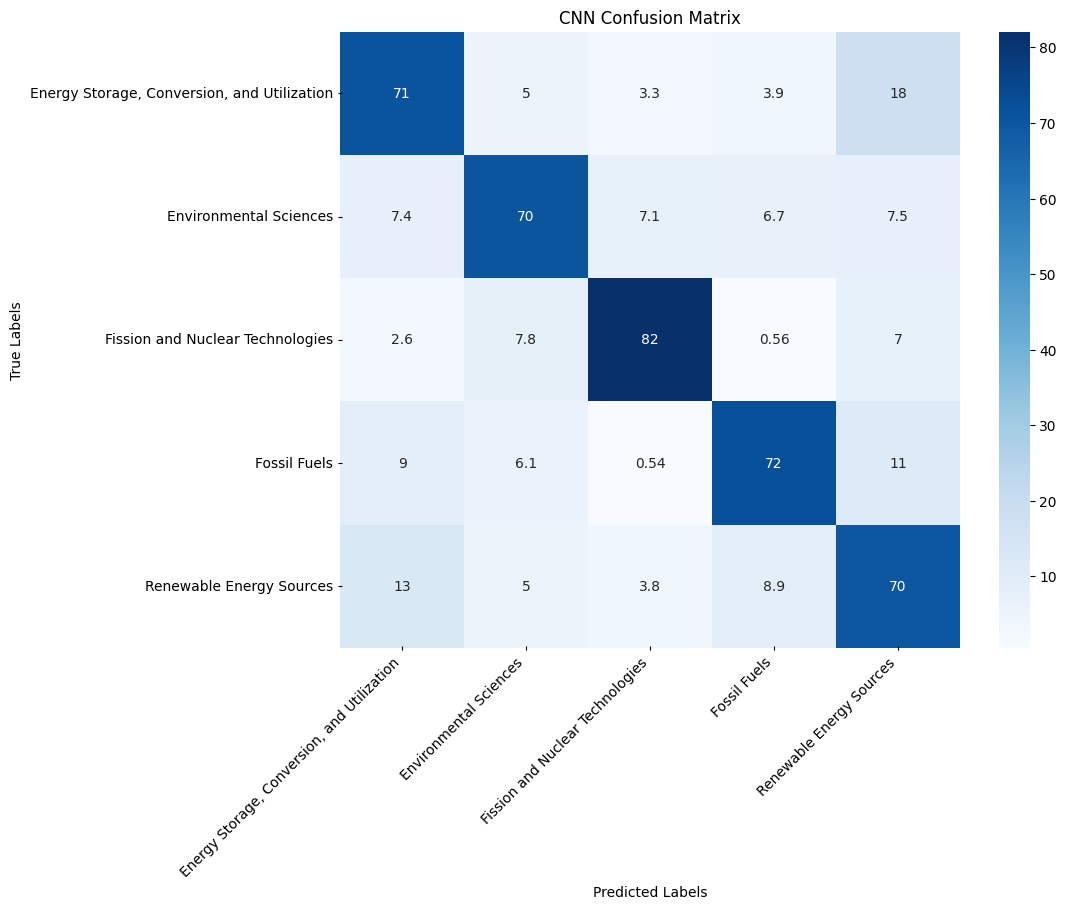

In [11]:
from sklearn import preprocessing
df = pd.read_csv(path)
df = df[['CLASS', 'SPACY_PREPROCESSED']]
df = df.dropna()
df['SPACY_PREPROCESSED'] = df['SPACY_PREPROCESSED'].str.replace(r'<[^<>]*>', '', regex=True) # drop HTML tags

le = preprocessing.LabelEncoder()
le.fit(df['CLASS'])
df['LABEL'] = le.transform(df['CLASS'])
df['LABEL'].value_counts(dropna=False)

tmp_dict = df[['CLASS', 'LABEL']].drop_duplicates().set_index('LABEL').to_dict('index')
CATEGORY_DICT = {label: sub_dict['CLASS'] for label, sub_dict in tmp_dict.items()}
list(CATEGORY_DICT.values())

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axis import XAxis as ax
import seaborn as sns

cm = confusion_matrix(Y_actual, Y_preds)
cm = (cm / cm.sum(axis=1)) * 100

# Create a heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=list(CATEGORY_DICT.values()), yticklabels=list(CATEGORY_DICT.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Confusion Matrix')
plt.tick_params(direction='inout')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()